In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%load_ext watermark

# Chapter 6: Monte Carlo simulations in finance

## Simulating Stock Prices' Dynamics using Geometric Brownian Motion

### How to do it...

1. Import libraries:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [5]:
%watermark --iversions

pandas     0.24.2
yfinance   0.1.42
numpy      1.16.2
json       2.0.9
matplotlib 3.0.3
autopep8   1.4.4



2. Define parameters for downloading data:

In [8]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

3. Download data from Yahoo Finance:

In [9]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 downloaded
Downloaded 146 rows of data.


4. Calculate daily returns:

Average return: 0.0%


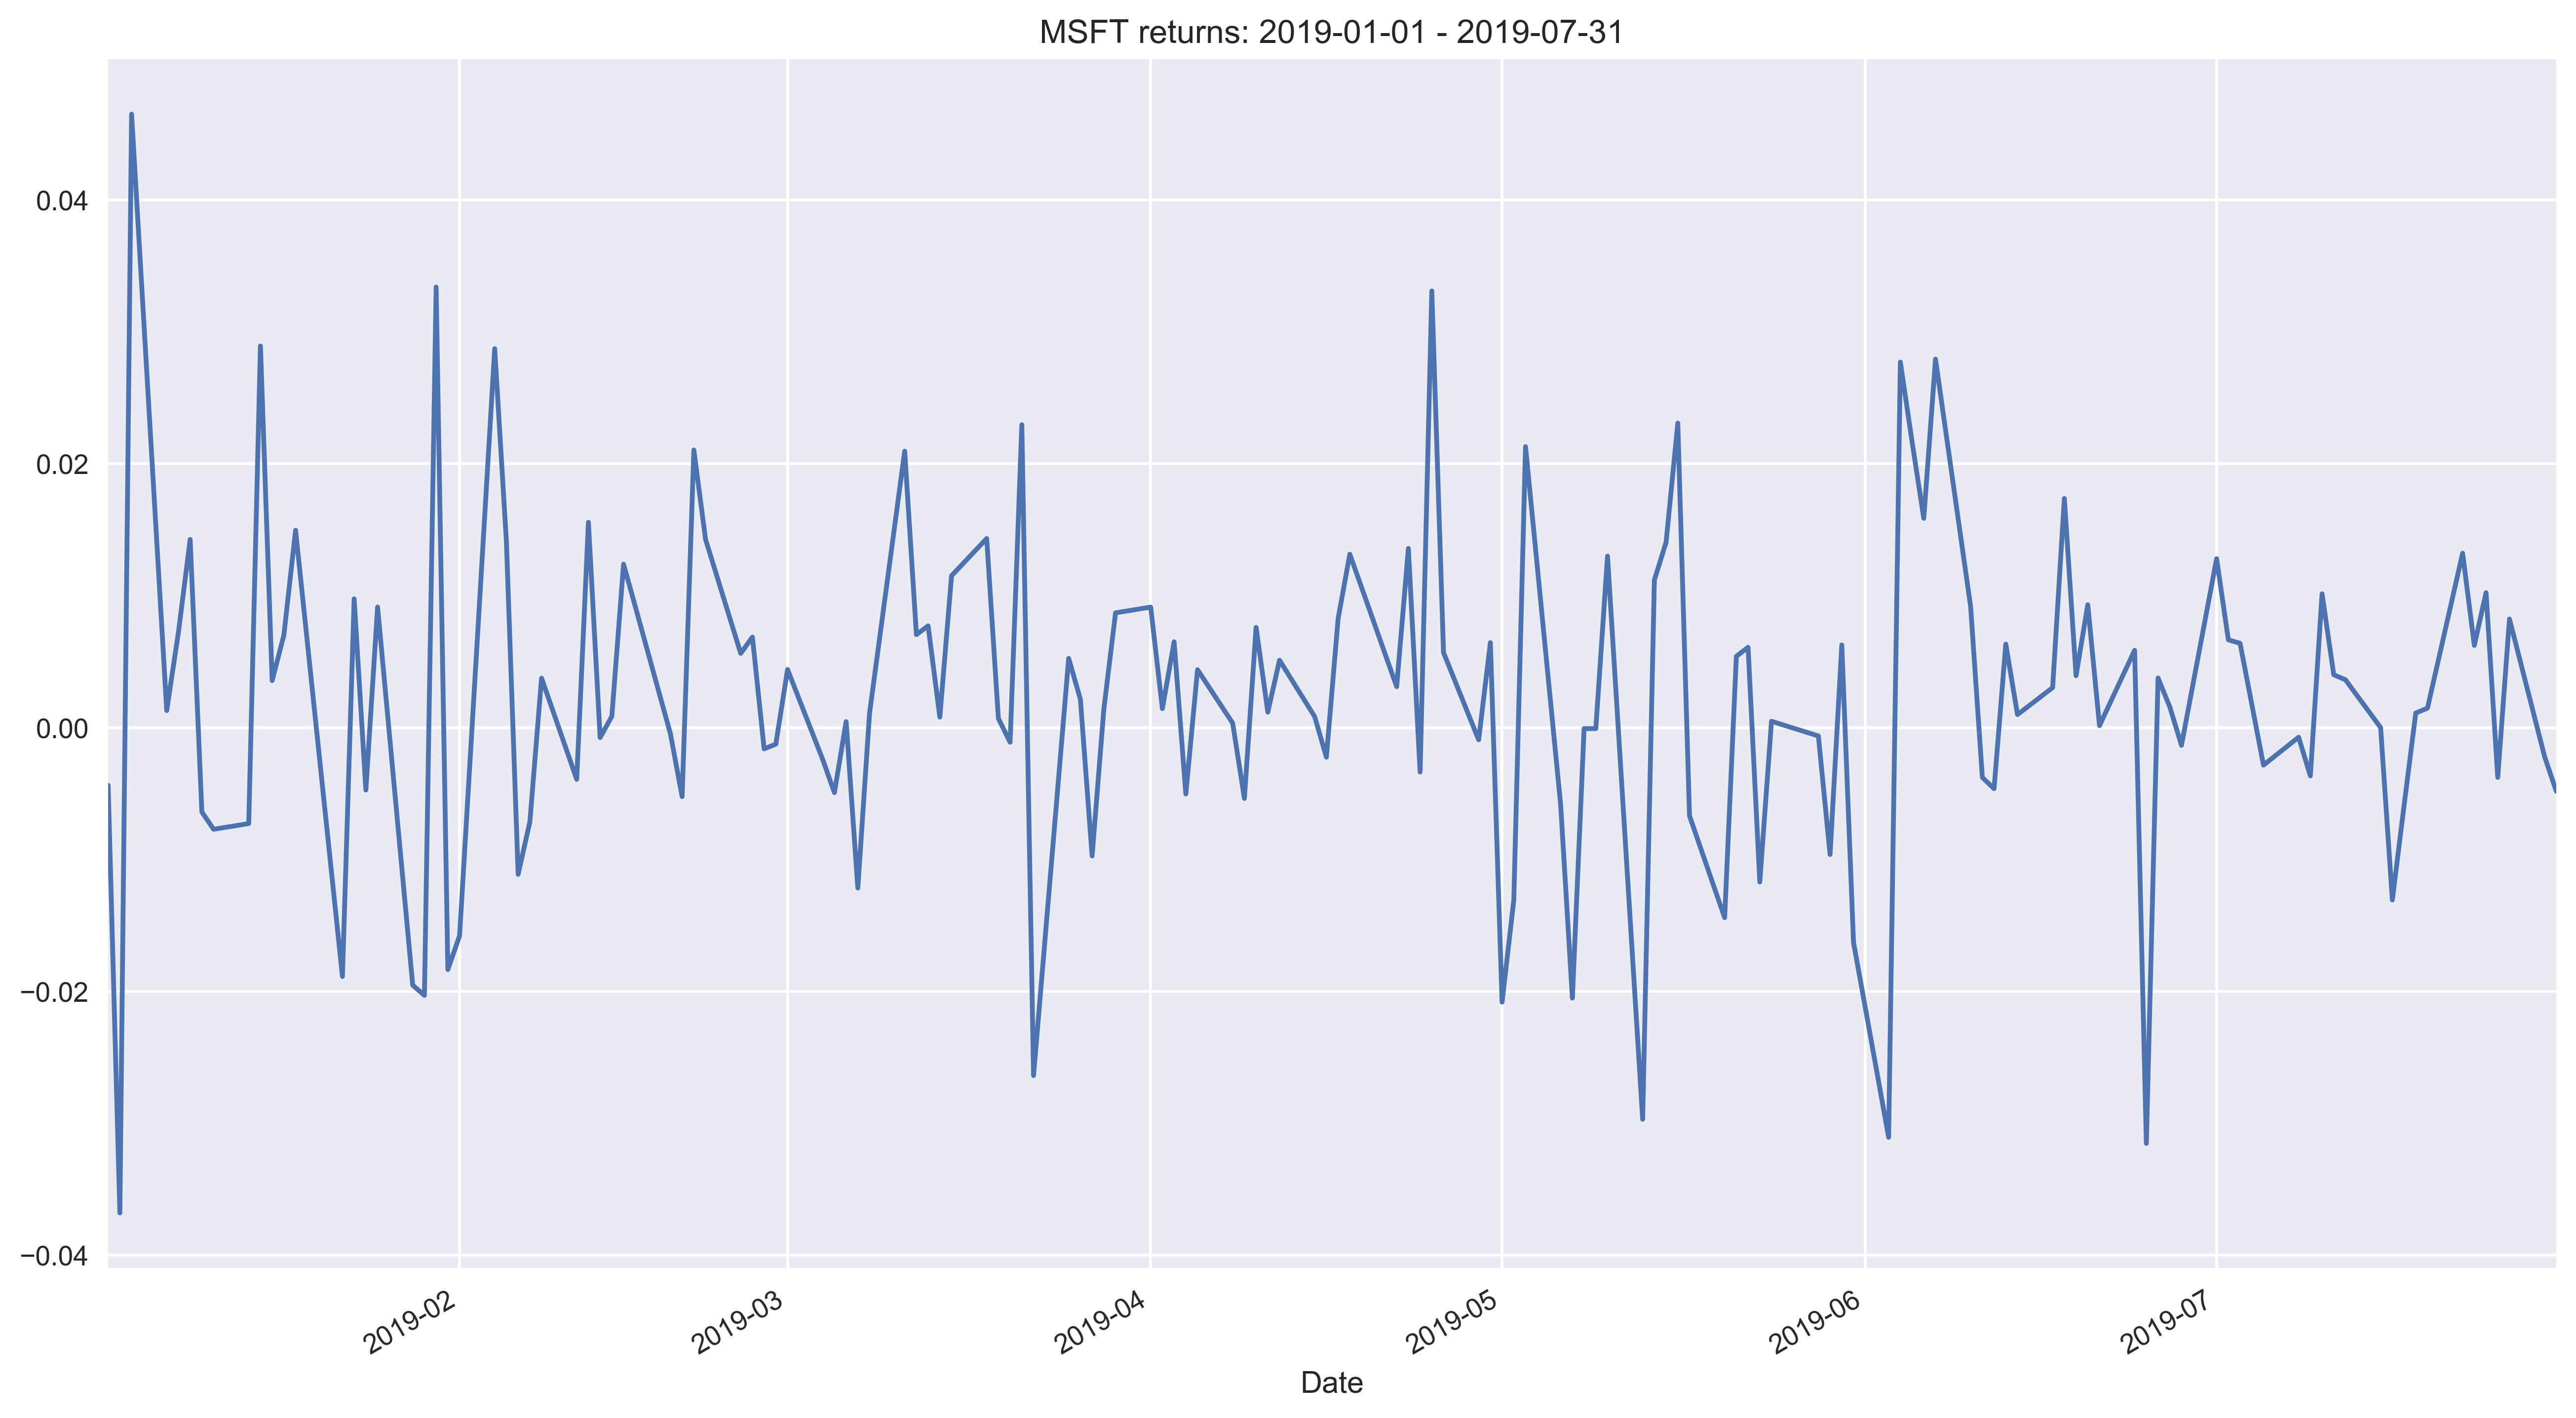

In [10]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}');

5. Split data into train and test set:

In [11]:
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

6. Specify the parameters of the simulation:

In [12]:
# GBM parameters
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1].date()]
N_SIM = 100
MU = train.mean()
SIGMA = train.std()

7. Define the function used for simulations:

In [6]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    # time increment
    dt = T/N
    # Brownian increments
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    # Brownian path
    W = np.cumsum(dW, axis=1)
    # calculate the timesteps
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    # simulate the evolution of the process
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

8. Run the simulations:

In [14]:
gbm_simulations = simulate_gbm(S_0, MU, SIGMA, N_SIM, T, N)

9. Plot simulation results:

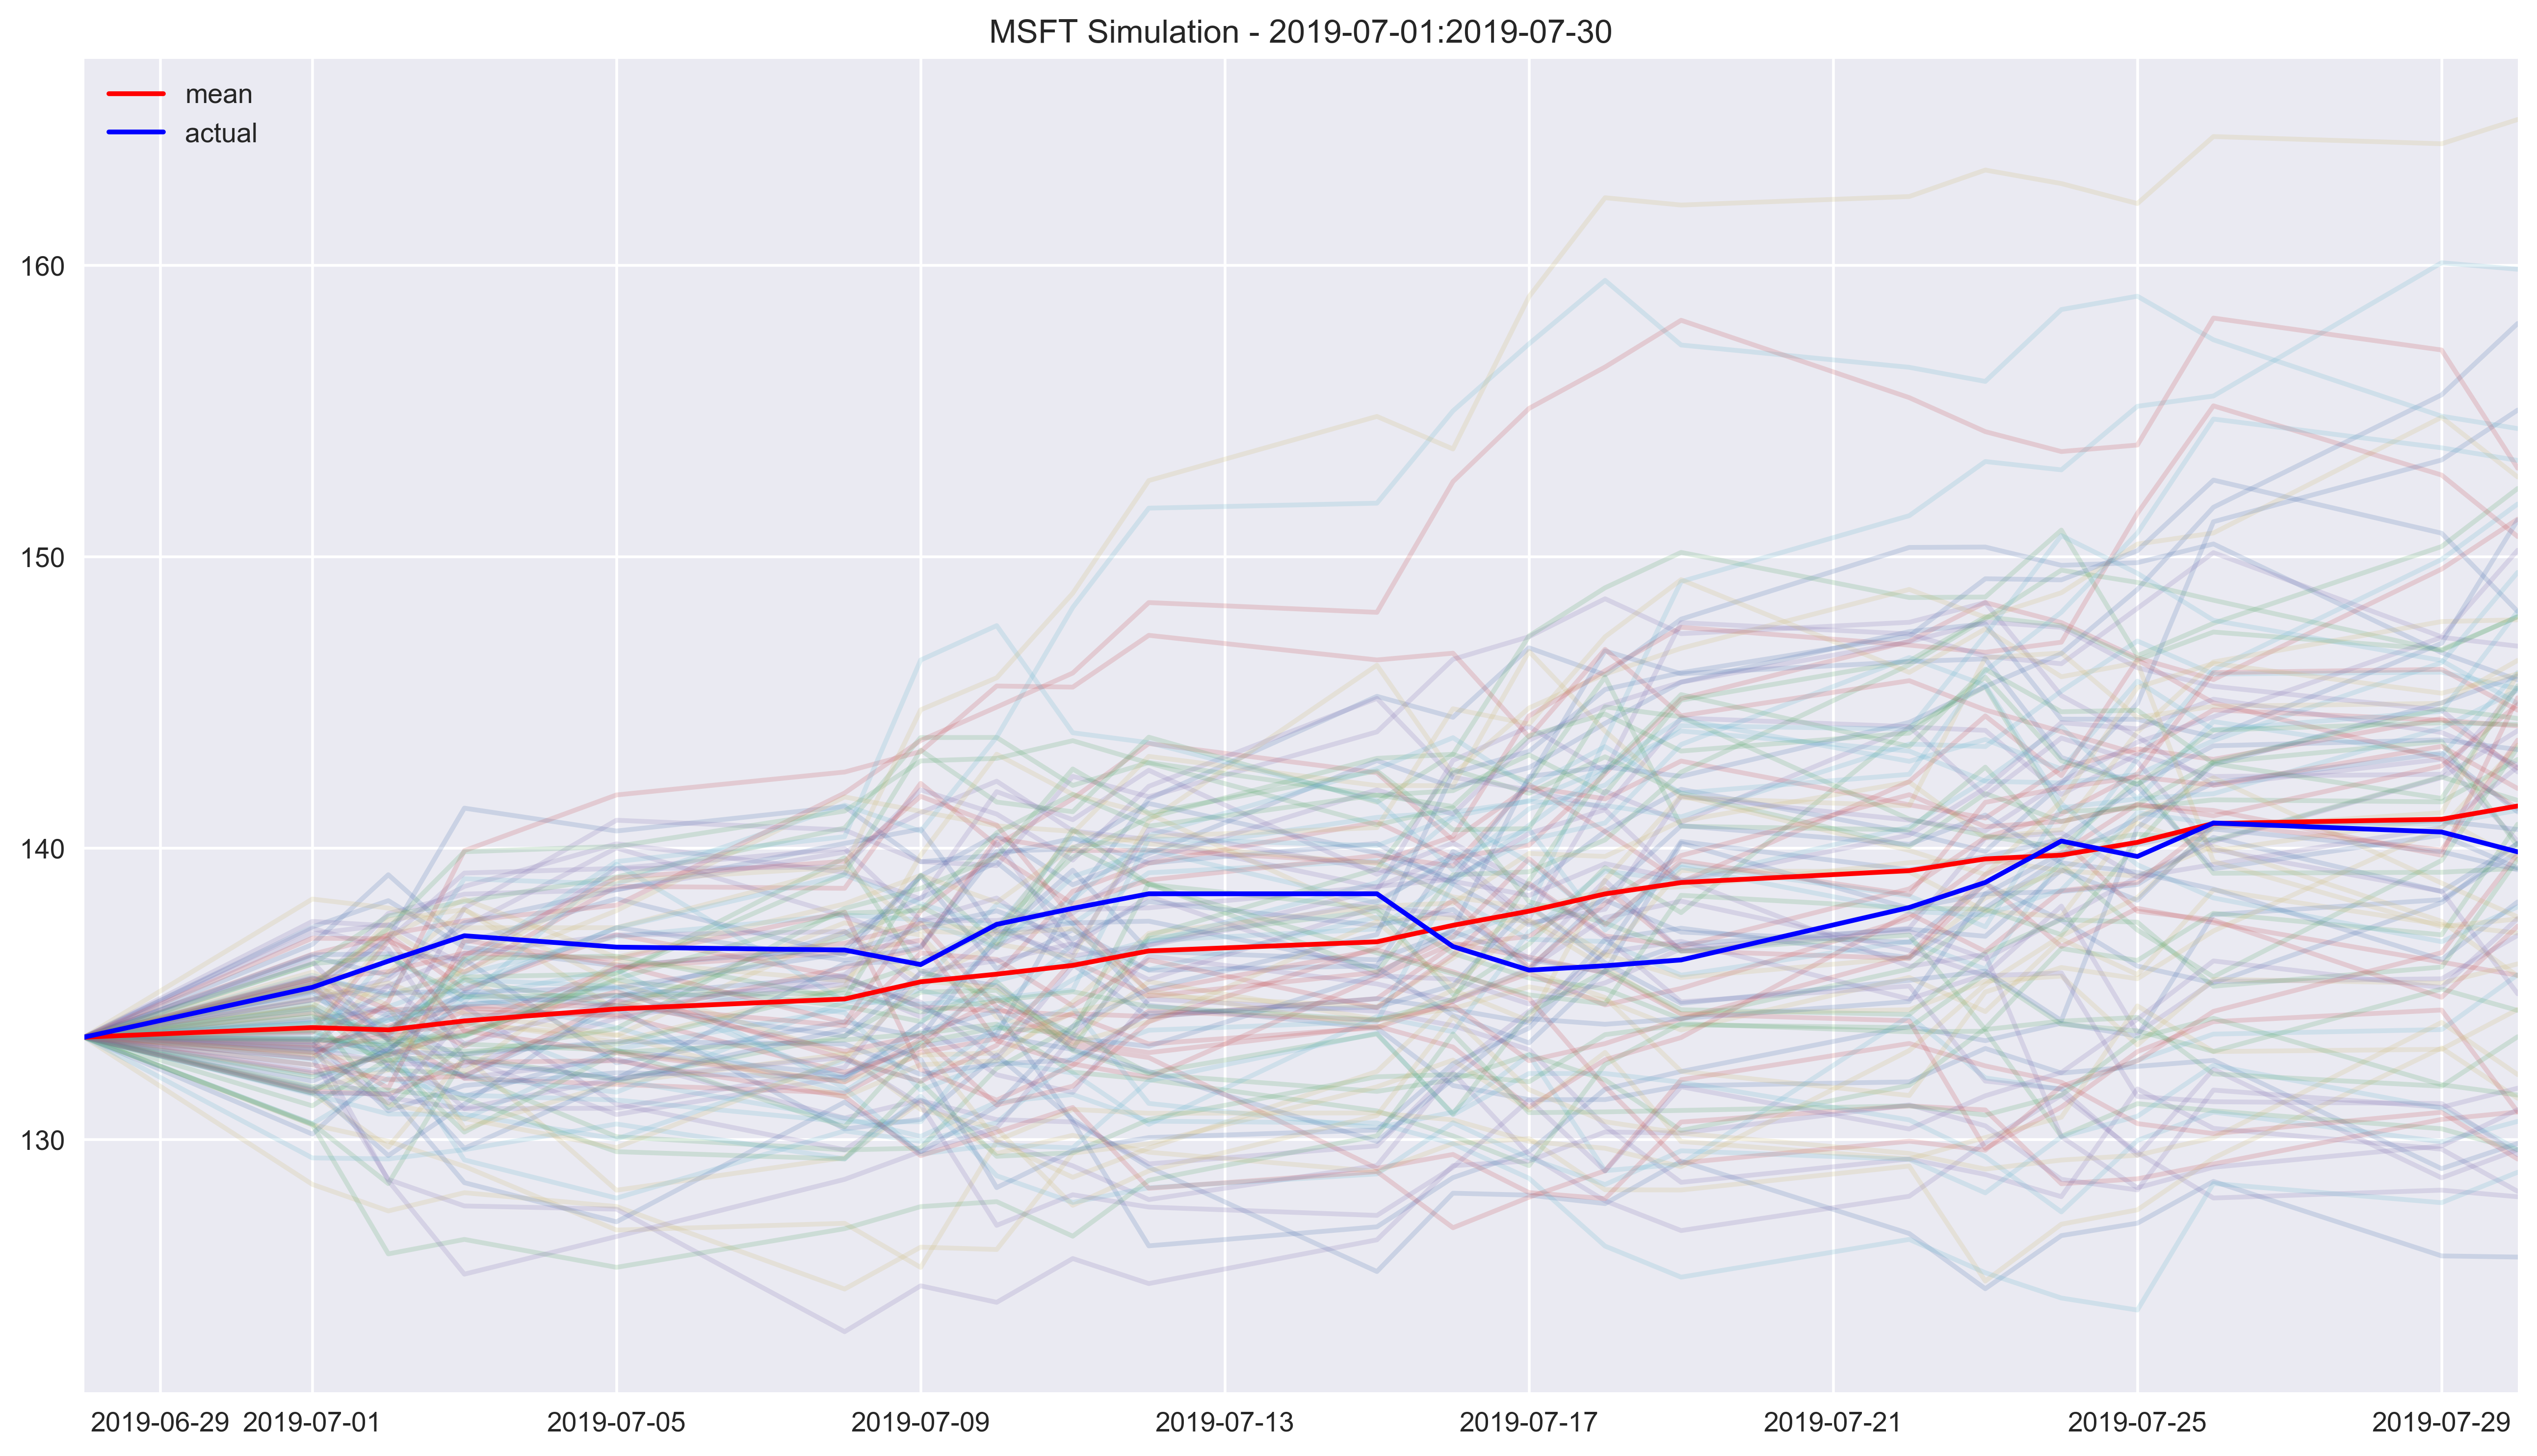

In [15]:
# prepare objects for plotting 
LAST_TRAIN_DATE = train.index[-1].date()
FIRST_TEST_DATE = test.index[0].date()
LAST_TEST_DATE = test.index[-1].date()
PLOT_TITLE = f'{RISKY_ASSET} Simulation - {FIRST_TEST_DATE}:{LAST_TEST_DATE}'
index = [date.date() for date in adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE].index]
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)

# plotting
ax = gbm_simulations_df.plot(title=PLOT_TITLE, alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), color='red')
line_2, = ax.plot(index, adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE], color='blue')
ax.legend((line_1, line_2), ('mean', 'actual'))

### There's more 

In [16]:
%timeit gbm_simulations = simulate_gbm(S_0, MU, SIGMA, N_SIM, T, N)

171 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [16]:
%timeit gbm_simulations = simulate_gbm(S_0, MU, SIGMA, N_SIM, T, N)

94.3 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit gbm_simulations = simulate_gbm(S_0, MU, SIGMA, N_SIM, T, N, antithetic_var=True)

66.3 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Pricing European Options using Simulations 

### How to do it...

1. Import the libraries:

In [17]:
import numpy as np
from scipy.stats import norm

2. Define the parameters for the valuation:

In [4]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
n_sims = 1000000 # number of simulations 
discount_factor = np.exp(-r * T)

3. Define the function using the analytical solution:

In [15]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        return (S_0 * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    elif type == 'put':
        return (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S_0 * norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError('Wrong input for type!')

4. Valuate a call option using the specified parameters:

In [6]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

5. Simulate the stock path using GBM:

In [7]:
gbm_simulations = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=n_sims, T=T, N=N)

6. Calculate the option premium:

In [8]:
option_premium = discount_factor * np.average(np.maximum(0, gbm_simulations[:, -1] - K))
option_premium

21.799416014608372

### There's more

In [9]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

In [10]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, type):
    '''
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Allowable: ['call', 'put']
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    '''
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal(0, 1, size=n_sims))

    if type == 'call':
        payoff = np.maximum(0, S_T - K)
    elif type == 'put':
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError('Wrong input for type!')
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

In [11]:
european_option_simulation(S_0, K, T, r, sigma, n_sims, type='put')

16.919422337796103

## Pricing American Options with Least Squares Monte Carlo

### How to do it...

1. Import libraries:

In [1]:
import numpy as np

2. Define the parameters:

In [2]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
n_sims = 10 ** 5 
discount_factor = np.exp(-r * dt)
option_type = 'put'
POLYNOMIAL_DEGREE = 5 

3. Simulate the stock prices using GBM:

In [57]:
gbm_simulations = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=n_sims, T=T, N=N)

4. Calculate the payoff matrix:

In [58]:
payoff_matrix = np.maximum(K - gbm_simulations, np.zeros_like(gbm_simulations))

5. Define the value matrix and fill the last column (time T):

In [59]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

6. Iteratively calculate the continuation value and the value vector in the given time:

In [60]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_simulations[:, t], value_matrix[:, t + 1] * discount_factor, POLYNOMIAL_DEGREE)
    continuation_value = np.polyval(regression, gbm_simulations[:, t])
    value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value,
                                  payoff_matrix[:, t],
                                  value_matrix[:, t + 1] * discount_factor)

7. Calculate the option premium:

In [61]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {option_type} option is {option_premium:.3f}')

The premium on the specified American put option is 4.453


8. Calculate the premium of a European put with the same parameters:

In [62]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

3.84430779159684

9. As an extra check, calculate the prices of American and European call options:

In [63]:
def lsmc_american_option(S_0, K, T, r, sigma, n_sims, option_type, poly_degree):
    '''
    Function used for calculating the price of American options using Least Squares Monte Carlo 
    algorithm of Longstaff and Schwartz (2001).
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    option_type : str
        Type of the option. Allowable: ['call', 'put']
    poly_degree : int
        Degree of the polynomial to fit in the LSTM algorithm
        
    Returns
    -----------
    option_premium : float
        The premium on the option 
    '''
        
    gbm_simulations = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=n_sims, T=T, N=N)
    
    if option_type == 'call':
        payoff_matrix = np.maximum(gbm_simulations - K, np.zeros_like(gbm_simulations))
    elif option_type == 'put':
        payoff_matrix = np.maximum(K - gbm_simulations, np.zeros_like(gbm_simulations))
    
    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]
    
    for t in range(N - 1, 0 , -1):
        regression = np.polyfit(gbm_simulations[:, t], value_matrix[:, t + 1] * discount_factor, poly_degree)
        continuation_value = np.polyval(regression, gbm_simulations[:, t])
        value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value,
                                      payoff_matrix[:, t],
                                      value_matrix[:, t + 1] * discount_factor)
    
    option_premium = np.mean(value_matrix[:, 1] * discount_factor)
    return option_premium

In [64]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, r=r, sigma=sigma, n_sims=n_sims, option_type='call', poly_degree=5)
print(f"The price of the European call is {european_call_price:.3f}, and the American call's price ({n_sims} simulations) is {american_call_price:.3f}")

The price of the European call is 2.174, and the American call's price (100000 simulations) is 2.078


## Pricing American Options using Quantlib

### How to do it...

1. Import the library:

In [3]:
import QuantLib as ql

2. Specify the calendar we want to use and the day counting convention:

In [4]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

3. Specify the valuation date and the expiry date of the option:

In [5]:
valuation_date = ql.Date(1, 1, 2018)
expiry_date =  ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = valuation_date

4. Define the option type (call/put), type of exercise (European/American/Bermudan) and the pay-off:

In [7]:
if option_type == 'call':
    option_type_ql = ql.Option.Call
elif option_type == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [8]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [9]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), day_counter)

7. Plug in the market-related data into the BS process:

In [10]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for the American options:

In [16]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, polynomOrder=POLYNOMIAL_DEGREE, 
                             seedCalibration=42, requiredSamples=n_sims)

9. Instantiate the option object and set its pricing engine:

In [17]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

10. Calculate the option premium:

In [18]:
option_premium_ql = option.NPV()

In [19]:
print(f'The value of the American {option_type} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.457


### There's more

In [ ]:
u_0 = u.value() # original value
h = 0.005

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

## Estimating Value-at-risk using Monte Carlo

### How to do it...

1. Import libraries:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [5]:
%watermark --iversions

matplotlib 3.0.3
seaborn    0.9.0
pandas     0.24.2
yfinance   0.1.42
json       2.0.9
autopep8   1.4.4
numpy      1.16.2



In [6]:
# set seed
np.random.seed(123)

2. Define parameters used for the exercise:

In [8]:
RISKY_ASSETS = ['GOOG', 'FB']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [9]:
df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  2 of 2 downloaded
Downloaded 250 rows of data.


In [10]:
df.head()

Adj Close            Close             High              Low  \
                  FB     GOOG      FB     GOOG      FB     GOOG      FB   
Date                                                                      
2018-01-02    181.42  1065.00  181.42  1065.00  181.58  1066.94  177.55   
2018-01-03    184.67  1082.48  184.67  1082.48  184.78  1086.29  181.33   
2018-01-04    184.33  1086.40  184.33  1086.40  186.21  1093.57  184.10   
2018-01-05    186.85  1102.23  186.85  1102.23  186.90  1104.25  184.93   
2018-01-08    188.28  1106.94  188.28  1106.94  188.90  1111.27  186.33   

                       Open             Volume           
               GOOG      FB     GOOG        FB     GOOG  
Date                                                     
2018-01-02  1045.23  177.68  1048.34  18151900  1237600  
2018-01-03  1063.21  181.88  1064.31  16886600  1430200  
2018-01-04  1084.00  184.90  1088.00  13880900  1004600  
2018-01-05  1092.00  185.59  1094.00  13574500  1279100  
2018-01-08  1101.62  187.20  1102.23  17994700  1047600

4. Calculate daily returns:

Correlation between returns: 0.62


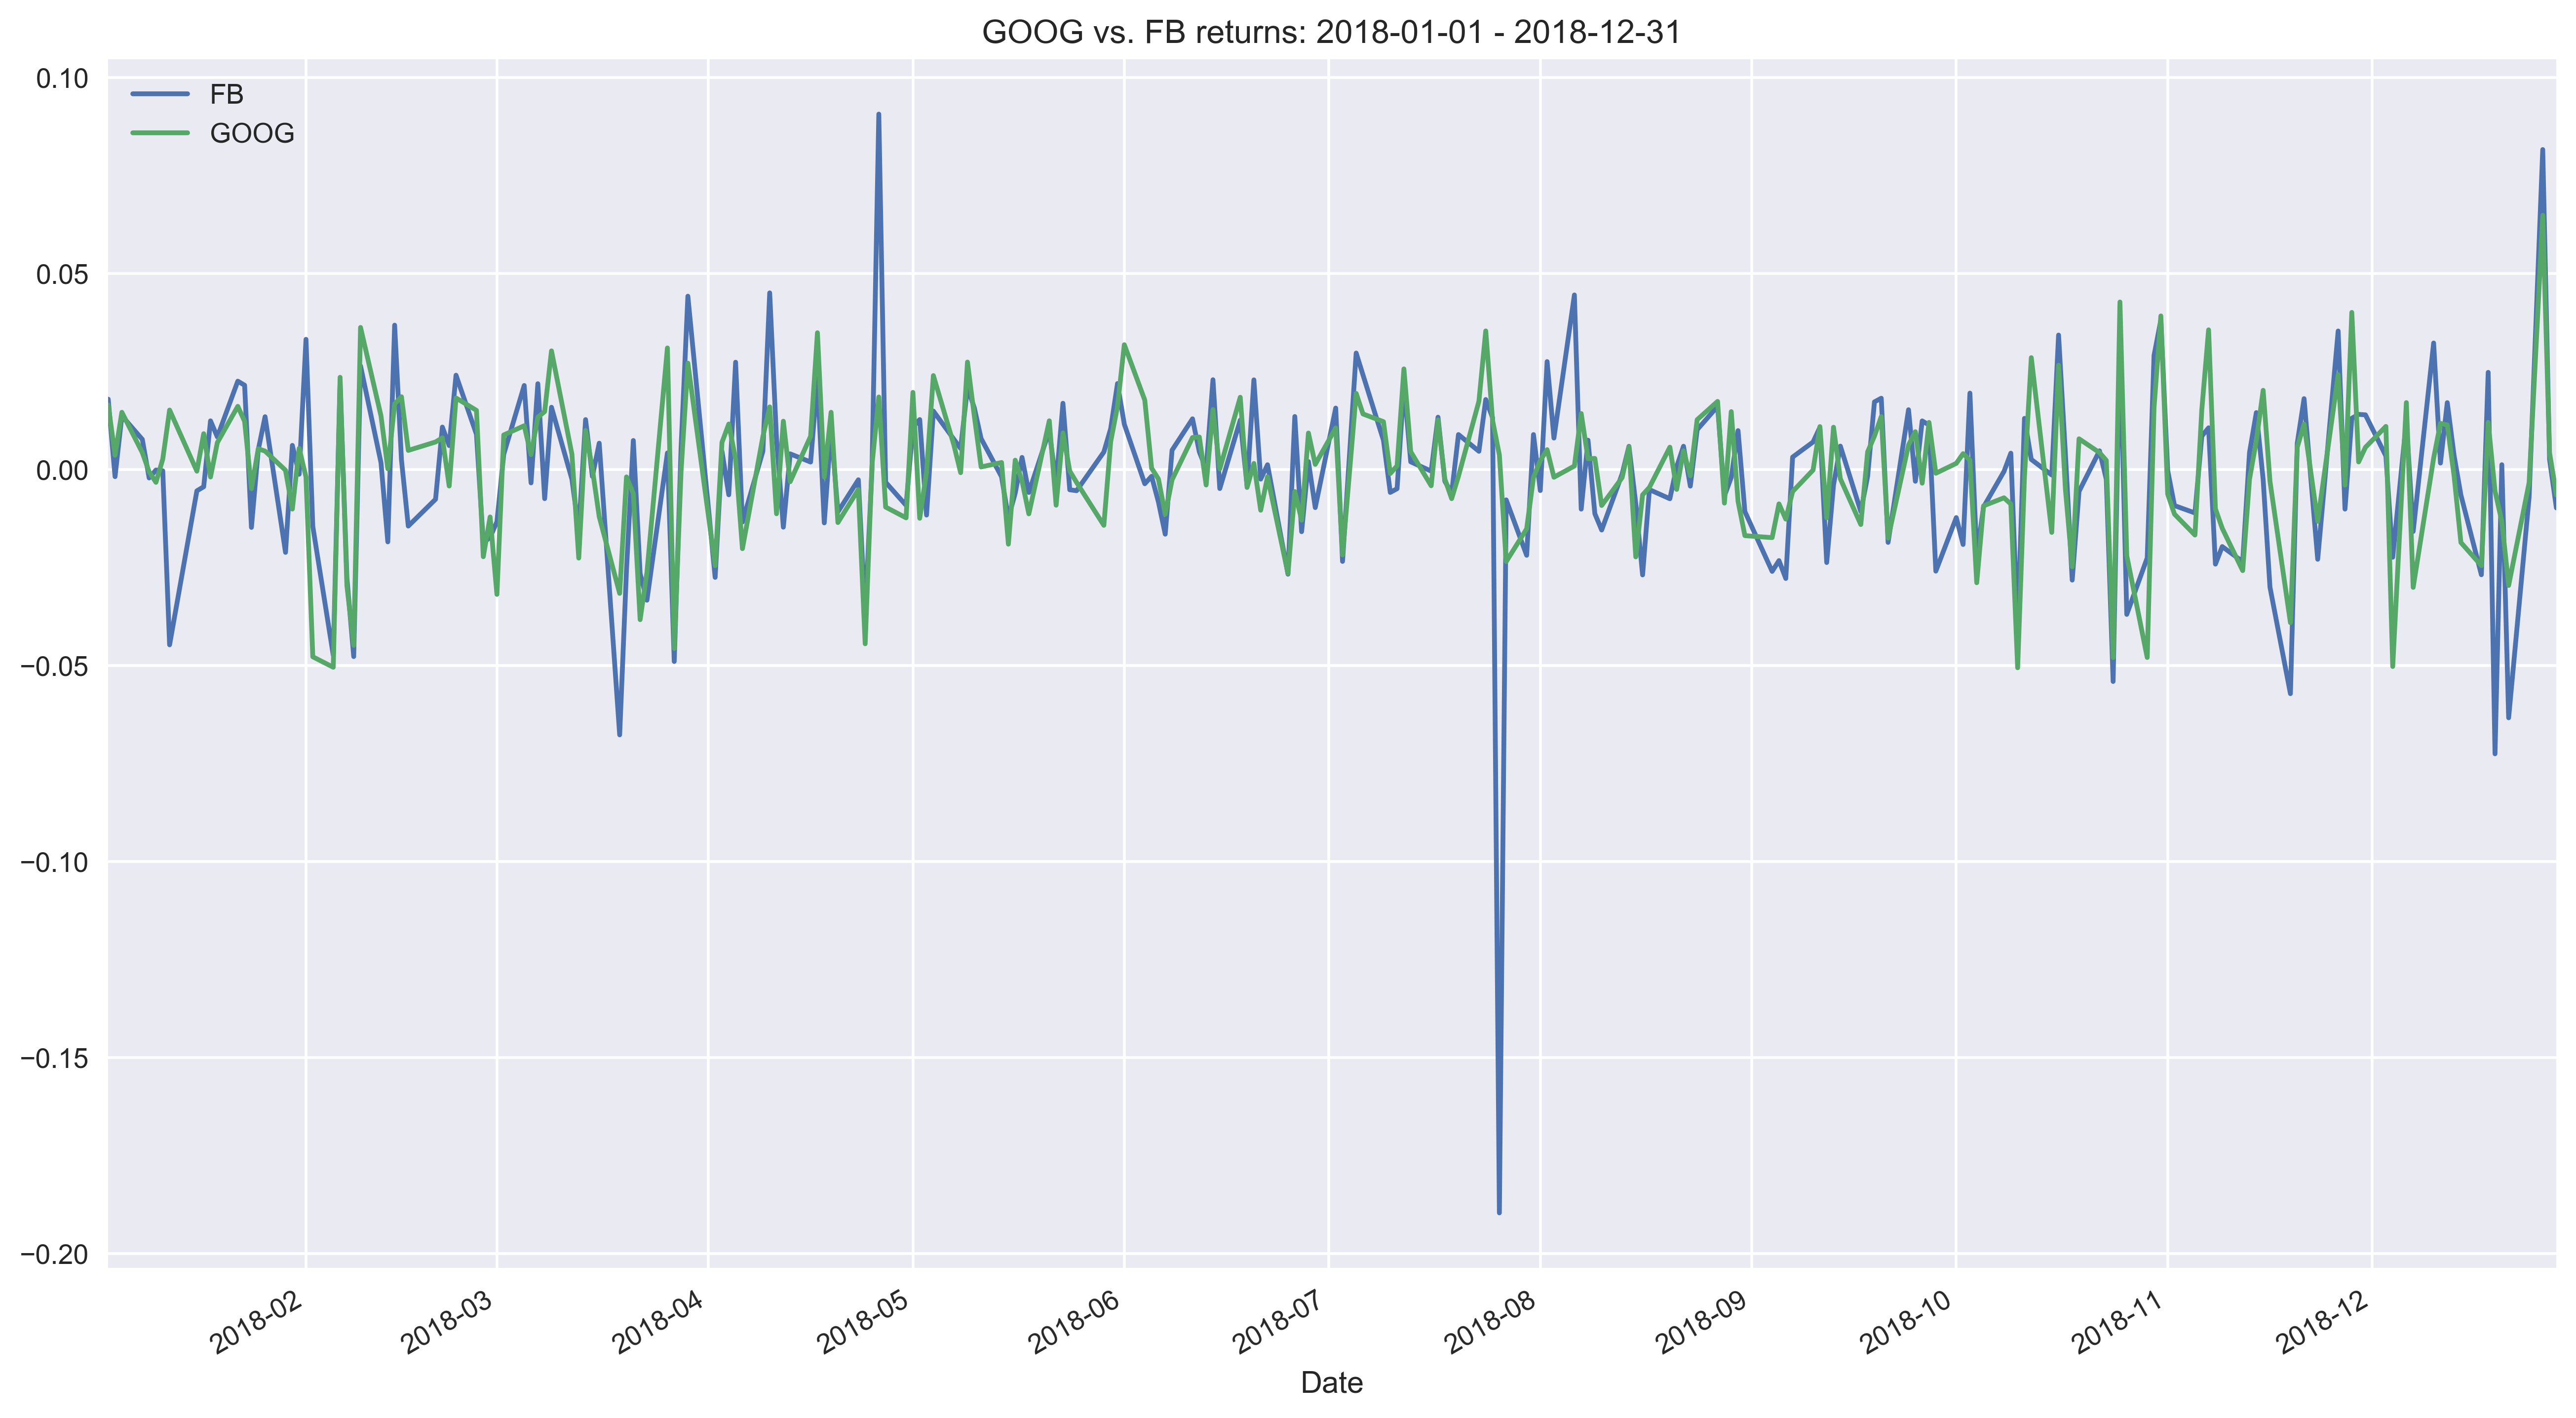

In [11]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
returns.plot(title=f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}');
print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

5. Calculate the covariance matrix:

In [12]:
cov_mat = returns.cov()
cov_mat

FB      GOOG
FB    0.000575  0.000265
GOOG  0.000265  0.000315

6. Perform the Cholesky decomposition of the covariance matrix:

In [13]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02397822, 0.        ],
       [0.01105642, 0.01389753]])

7. Draw correlated random numbers from Standard Normal distribution:

In [14]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

In [15]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

9. Calculate the terminal price of the considered stocks:

In [16]:
S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * correlated_rv)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

In [17]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

11. Calculate VaR:

In [18]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 8.49$
1-day VaR with 99.9% confidence: 7.23$
1-day VaR with 99.0% confidence: 5.78$


12. Present the results on a graph:

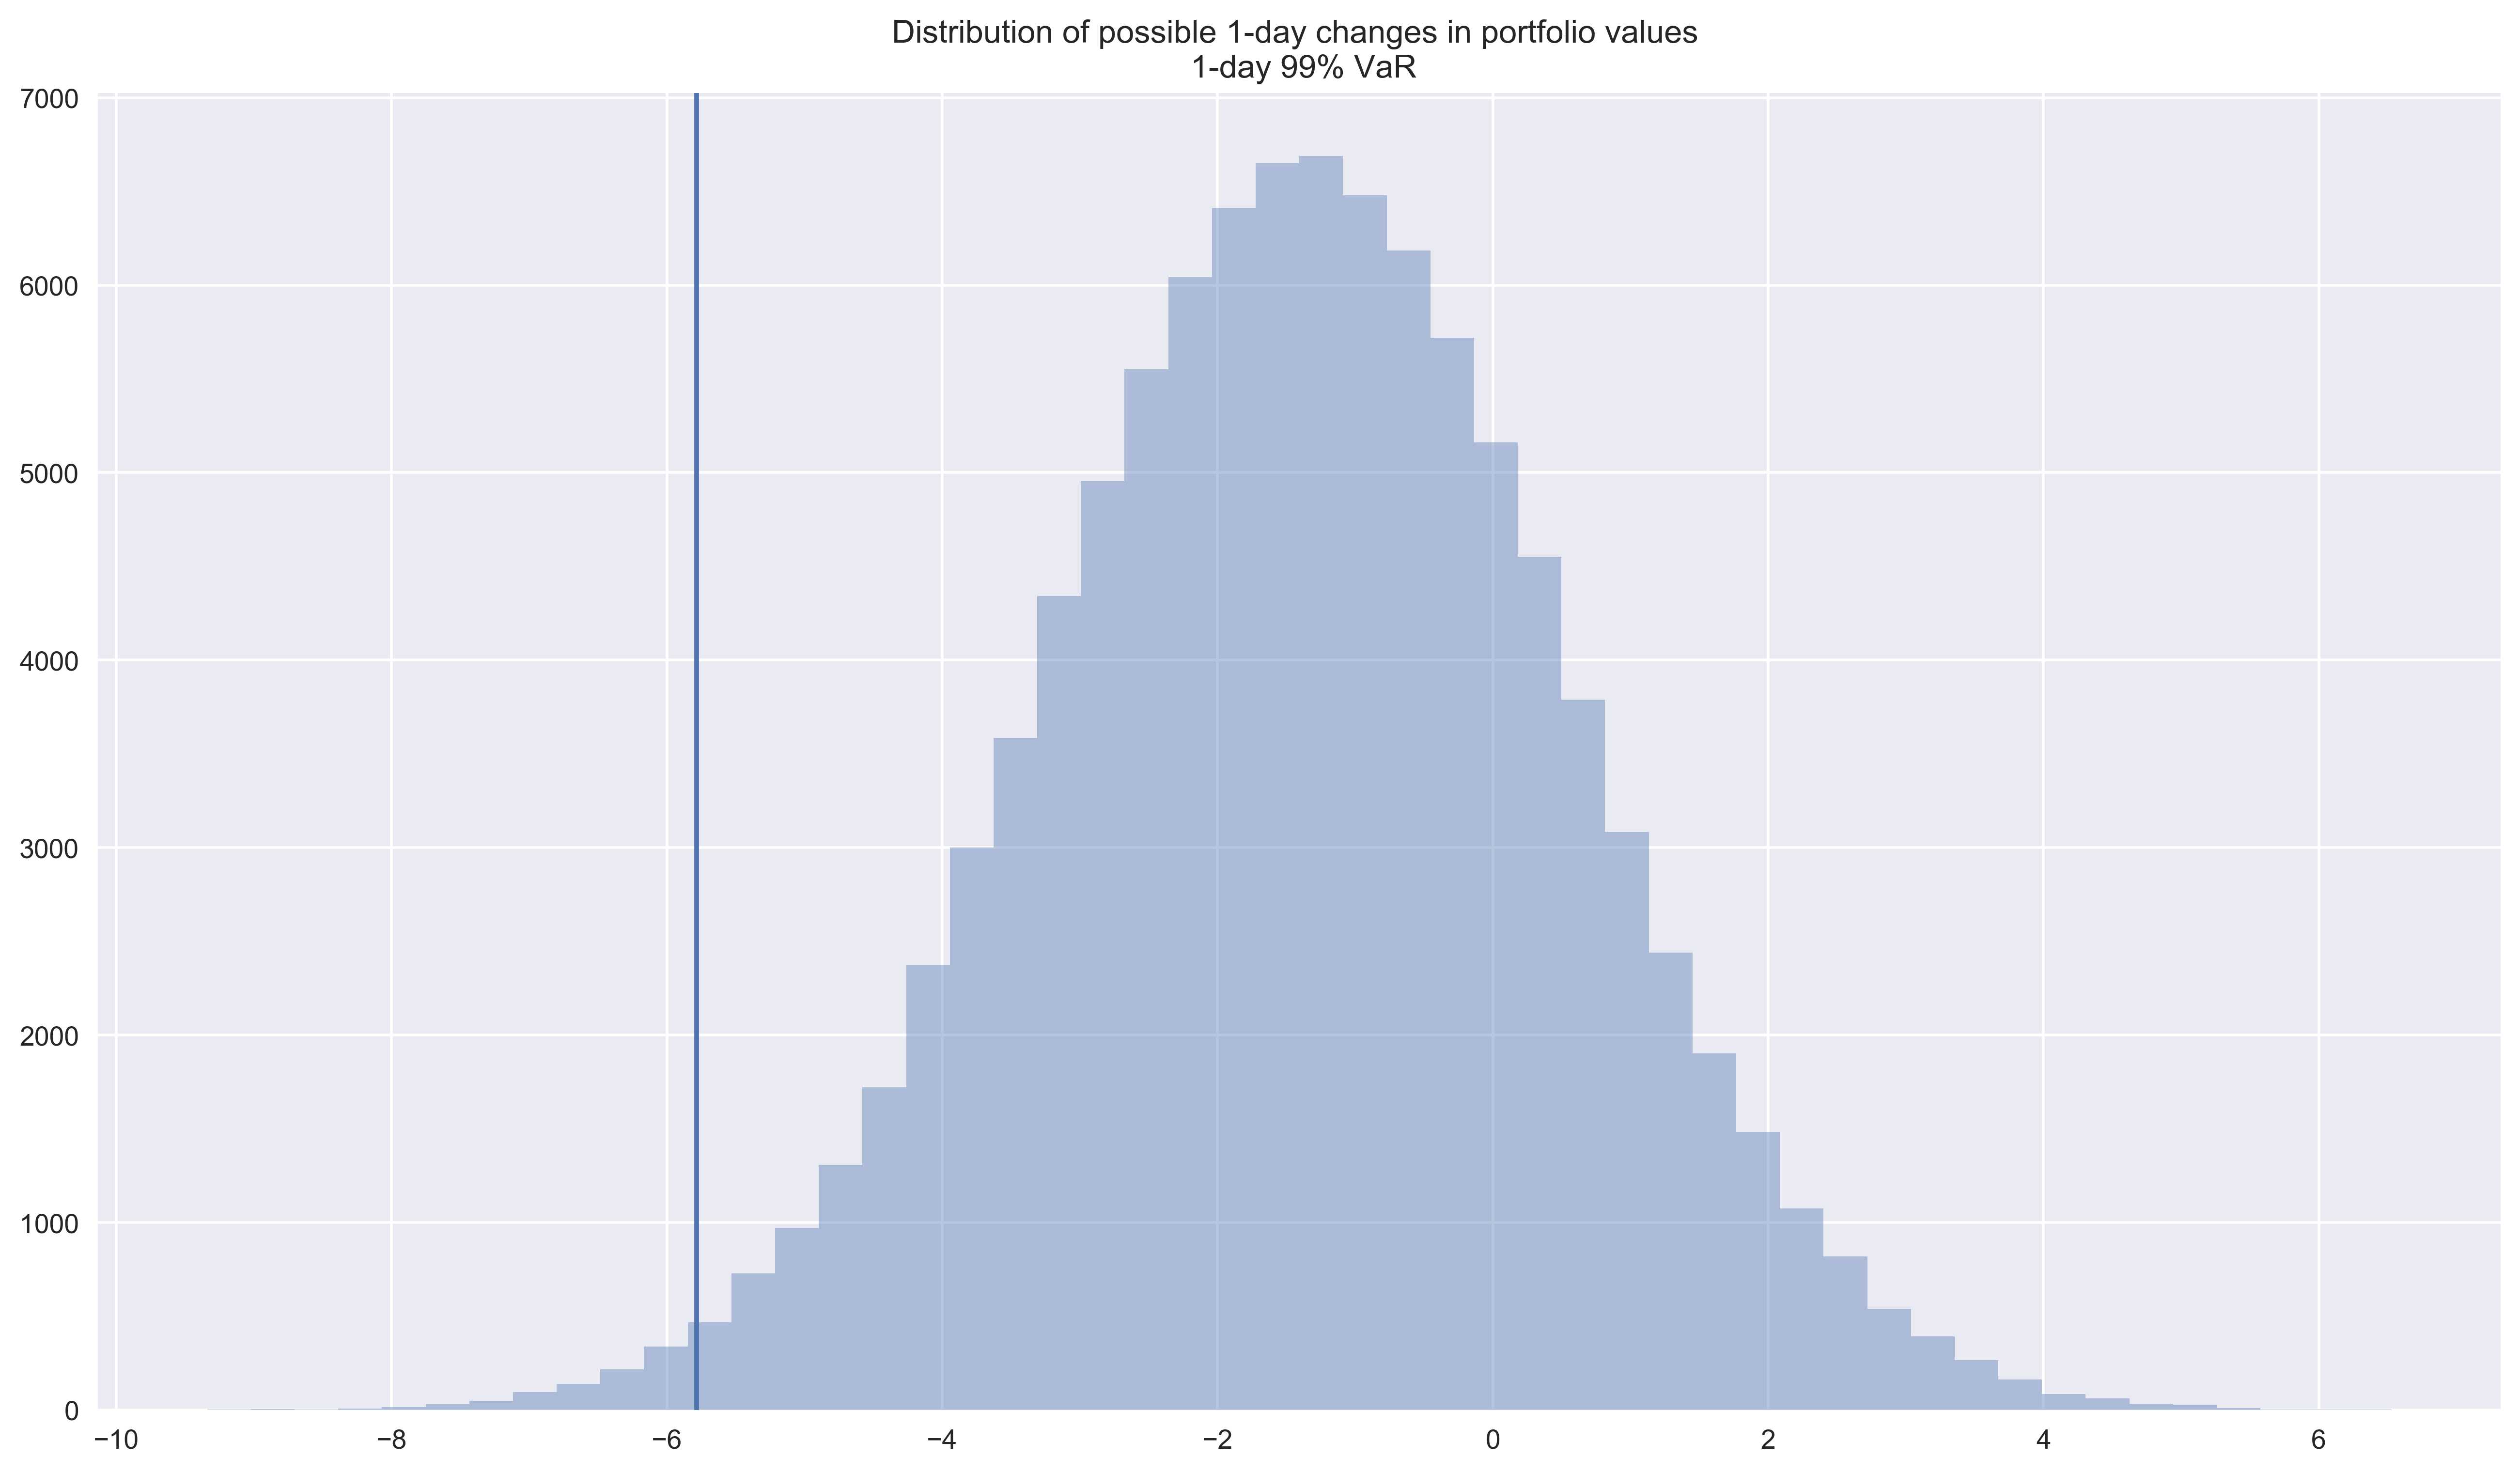

In [20]:
sns.distplot(P_diff, kde=False).set_title('Distribution of possible 1-day changes in portfolio values \n 1-day 99% VaR')
plt.axvline(var[2], 0, 10000)

### There's more

In [26]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()
print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 4.45$, and the accompanying Expected Shortfall is 5.27$
